<a href="https://colab.research.google.com/github/long-sleeper/diveintocode-ml/blob/master/term2/Sprint24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sprint  Seq2Seq

### ＜目的＞  
- 系列データに関する応用例を学ぶ

### ＜機械翻訳＞  
系列データに関する手法の基本的な活用例としては機械翻訳があります。これは系列データを入力し、系列データを出力する Sequence to Sequence の手法によって行えます。

### 【問題1】機械翻訳の実行とコードリーディング
Keras公式のサンプルコードで、短い英語からフランス語への変換を行うものが公開されています。これを動かしてください。

keras/lstm_seq2seq.py at master · keras-team/keras


その上でこのサンプルコードの各部分がどういった役割かを読み取り、まとめてください。以下のようにどこからどこの行が何をしているかを記述してください。


（例）


51から55行目 : ライブラリのimport  
57から62行目 : ハイパーパラメータの設定


**《文字単位のトークン化》**


この実装ではテキストのベクトル化の際に、単語ではなく文字ごとを1つのトークンとして扱っています。


scikit-learnでBoWを計算するCountVectorizerの場合では、デフォルトの引数は``analyzer=’word’``で単語を扱いますが、``char``や``char_wb``とすることで文字を扱えるようになります。


``char``と``char_wb``の2種類の方法があり、``char_wb``を指定した場合、n_gramが単語内からのみ作成されます。逆に``char``は単語の区切りが関係なくn_gramが作成されます。This movie is very good.というテキストを3-gramでカウントする時、``char``ではs mやe iといった単語をまたぐ数え方もしますが、``char_wb``ではこれらを見ません。


sklearn.feature_extraction.text.CountVectorizer — scikit-learn 0.21.3 documentation

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = '/content/drive/My Drive/Sprint24/fra-eng/fra.txt'

Using TensorFlow backend.


- ライブラリのインポート  
- ハイパーパラメーターの設定

In [7]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)


- 翻訳先（target_text）の文頭に'\t'挿入、文末に'\n'挿入  
- 単語のリスト化 (``input_textes``, ``target_texts``) 
- 単語からトークン(``characters``)を取得しリスト化

In [8]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [9]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 92
Max sequence length for inputs: 16
Max sequence length for outputs: 59


- サンプル数、入出力トークン数、入出力文の最大長確認

In [10]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

- トークンの辞書化（key:トークン, value:シーケンス）

In [11]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

- encoder / decoder の入出力を初期化 (サイズ：サンプル数, 文の最大長, トークン数)

In [12]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

- 文の各位置（シーケンス：t）における各トークンに該当するテーブルを 1 に置換
- decoderから``target_data``への出力は一つずれる
- encoderの定義 (LSTM)

In [ ]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

- decoderの定義 (LSTM → Dense)

In [ ]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

- 学習モデルの定義 

In [ ]:
% cd /content/drive/My Drive/Sprint24

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

/content/drive/My Drive/Sprint24
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 60s 7ms/step - loss: 1.1814 - accuracy: 0.7256 - val_loss: 1.0855 - val_accuracy: 0.6978
Epoch 2/100
8000/8000 [==============================] - 58s 7ms/step - loss: 0.8572 - accuracy: 0.7697 - val_loss: 0.8416 - val_accuracy: 0.7681
Epoch 3/100
8000/8000 [==============================] - 59s 7ms/step - loss: 0.7122 - accuracy: 0.8021 - val_loss: 0.7470 - val_accuracy: 0.7846
Epoch 4/100
8000/8000 [==============================] - 59s 7ms/step - loss: 0.6144 - accuracy: 0.8222 - val_loss: 0.6725 - val_accuracy: 0.8060
Epoch 5/100
8000/8000 [==============================] - 58s 7ms/step - loss: 0.5573 - accuracy: 0.8375 - val_loss: 0.6351 - val_accuracy: 0.8145
Epoch 6/100
8000/8000 [==============================] - 60s 7ms/step - loss: 0.5172 - accuracy: 0.8482 - val_loss: 0.5975 - val_accuracy: 0.8236
Epoch 7/100
8000/8000 [====================

- 学習、モデルの保存

In [ ]:
# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

- 推論encoderモデルの定義

In [ ]:
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

- 推論decoderモデルの定義

In [13]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

- トークンの逆引き辞書作成（key:シーケンス, value:トークン）

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

- 翻訳先のトークンを表示する関数の定義

In [ ]:
for seq_index in range(10):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Go.
Decoded sentence: Va !

-
Input sentence: Hi.
Decoded sentence: Salut.

-
Input sentence: Hi.
Decoded sentence: Salut.

-
Input sentence: Run!
Decoded sentence: Cours !

-
Input sentence: Run!
Decoded sentence: Cours !

-
Input sentence: Who?
Decoded sentence: Qui ?

-
Input sentence: Wow!
Decoded sentence: Ça alors !

-
Input sentence: Fire!
Decoded sentence: Au feu !

-
Input sentence: Help!
Decoded sentence: À l'aide !

-
Input sentence: Jump.
Decoded sentence: Saute.



- 推論の実行

### ＜イメージキャプショニング＞

他の活用例としてイメージキャプショニングがあります。画像に対する説明の文章を推定するタスクです。これは画像を入力し、系列データを出力する Image to Sequence の手法によって行えます。


pytorch-tutorial/tutorials/03-advanced/image_captioning at master · yunjey/pytorch-tutorial


イメージキャプショニングは学習に多くの時間がかかるため、ここでは学習済みの重みが公開されている実装を動かすことにします。Kerasには平易に扱える実装が公開されていないため、今回はPyTorchによる実装を扱います。
  
  


### 【問題2】イメージキャプショニングの学習済みモデルの実行
上記実装において 5. Test the model の項目を実行してください。また、自身で用意した画像に対しても文章を生成してください。これらに対してどういった文章が出力されたかを記録して提出してください。


データセットからの学習は行わず、学習済みの重みをダウンロードして利用します。


注意点として、デフォルトで設定されている重みのファイル名と、ダウンロードできる重みのファイル名は異なっています。ここは書き換える必要があります。



In [ ]:
! git clone https://github.com/pdollar/coco.git

Cloning into 'coco'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 13.82 MiB/s, done.
Resolving deltas: 100% (576/576), done.


In [ ]:
%cd coco/PythonAPI/

/content/drive/My Drive/Sprint24/coco/PythonAPI


In [ ]:
!python setup.py build

running build
running build_py
creating build
creating build/lib.linux-x86_64-3.6
creating build/lib.linux-x86_64-3.6/pycocotools
copying pycocotools/__init__.py -> build/lib.linux-x86_64-3.6/pycocotools
copying pycocotools/coco.py -> build/lib.linux-x86_64-3.6/pycocotools
copying pycocotools/cocoeval.py -> build/lib.linux-x86_64-3.6/pycocotools
copying pycocotools/mask.py -> build/lib.linux-x86_64-3.6/pycocotools
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/drive/My Drive/Sprint24/coco/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build/common
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pycocotools
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrap

In [ ]:
!python setup.py install

running install
running bdist_egg
running egg_info
creating pycocotools.egg-info
writing pycocotools.egg-info/PKG-INFO
writing dependency_links to pycocotools.egg-info/dependency_links.txt
writing requirements to pycocotools.egg-info/requires.txt
writing top-level names to pycocotools.egg-info/top_level.txt
writing manifest file 'pycocotools.egg-info/SOURCES.txt'
writing manifest file 'pycocotools.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
running build_ext
skipping 'pycocotools/_mask.c' Cython extension (up-to-date)
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/__init__.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/coco.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/cocoeval.py -> build/bdist.linux-x

In [ ]:
!git clone https://github.com/yunjey/pytorch-tutorial.git

Cloning into 'pytorch-tutorial'...
remote: Enumerating objects: 917, done.
remote: Total 917 (delta 0), reused 0 (delta 0), pack-reused 917
Receiving objects: 100% (917/917), 12.80 MiB | 15.37 MiB/s, done.
Resolving deltas: 100% (490/490), done.


In [ ]:
%cd pytorch-tutorial/tutorials/03-advanced/image_captioning/

[Errno 2] No such file or directory: 'pytorch-tutorial/tutorials/03-advanced/image_captioning/'
/content/drive/My Drive/Sprint24/coco/PythonAPI/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [ ]:
!unzip /content/drive/'My Drive'/Sprint24/pretrained_model.zip

Archive:  /content/drive/My Drive/Sprint24/pretrained_model.zip
replace encoder-5-3000.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: encoder-5-3000.pkl      
replace decoder-5-3000.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: decoder-5-3000.pkl      


In [ ]:
!unzip /content/drive/'My Drive'/Sprint24/vocap.zip

Archive:  /content/drive/My Drive/Sprint24/vocap.zip
replace vocab.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: vocab.pkl               


キリンのサンプル画像で推論

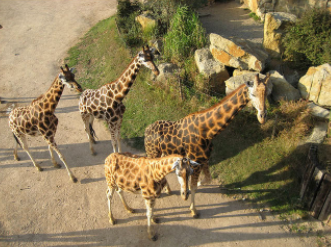

In [ ]:
from IPython.display import Image
Image('/content/drive/My Drive/Sprint24/pytorch-tutorial/tutorials/03-advanced/image_captioning/png/example.png')

In [ ]:
!python sample.py --image='png/example.png'

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100% 230M/230M [00:03<00:00, 74.6MB/s]
<start> a group of giraffes standing next to each other . <end>


適切な説明が得られている  


自分で用意した画像からも文章生成

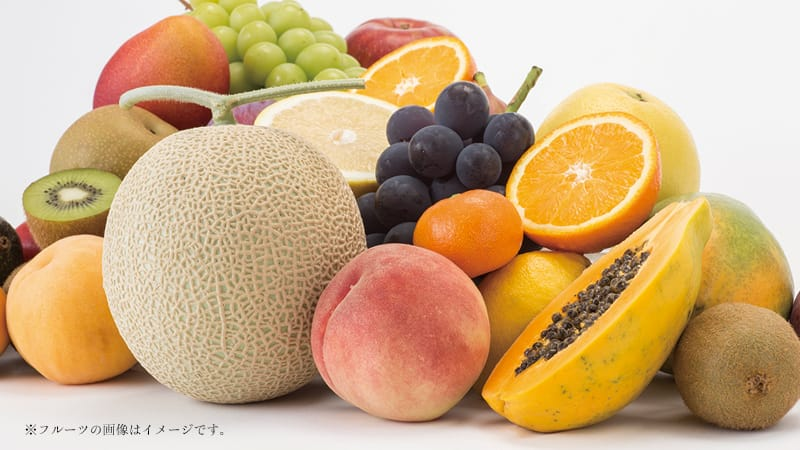

In [ ]:
Image('/content/drive/My Drive/Sprint24/pytorch-tutorial/tutorials/03-advanced/image_captioning/png/p1.jpg')

In [ ]:
!python sample.py --image='png/p1.jpg'

<start> a bunch of oranges sitting on a table . <end>


オレンジの束がテーブルの上に座っている…  
オレンジ以外の果物は認識されないか

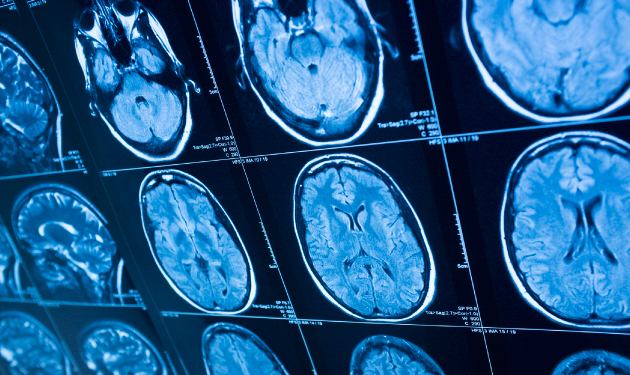

In [ ]:
Image('/content/drive/My Drive/Sprint24/pytorch-tutorial/tutorials/03-advanced/image_captioning/png/p2.jpg')

In [ ]:
!python sample.py --image='png/p2.jpg'

<start> a bunch of different types of scissors on a shelf . <end>


色々な種類のハサミが棚に並んでいる…  
脳の構造の一部がハサミにみえるようだ

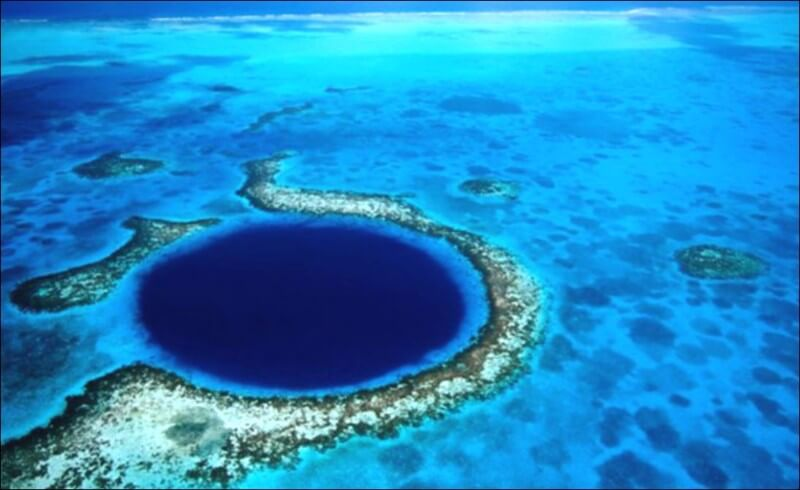

In [ ]:
Image('/content/drive/My Drive/Sprint24/pytorch-tutorial/tutorials/03-advanced/image_captioning/png/p3.jpg')

In [ ]:
!python sample.py --image='png/p3.jpg'

<start> a white plate with a white plate and a cup on it . <end>


上にカップが載っている白いプレート…  
難しすぎる画像だった

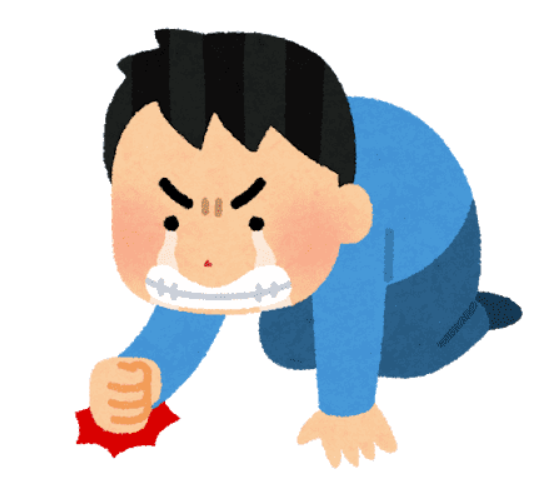

In [ ]:
Image('/content/drive/My Drive/Sprint24/pytorch-tutorial/tutorials/03-advanced/image_captioning/png/p4.png')

In [ ]:
!python sample.py --image='png/p4.png'

<start> a small child wearing a red shirt and a red tie . <end>


赤いシャツを着て、赤いネクタイをしている小さな子供…  
床を叩いた赤い効果に注意が向いているようだ

### 【問題3】Kerasで動かしたい場合はどうするかを調査
PyTorchによる実装を動かしましたが、何らかの理由からKerasで動かしたい状況が考えられます。どういった手順を踏むことになるか調査し、できるだけ詳しく説明してください。


特に今回はPyTorchのための学習済みの重みをKerasで使えるようにしたいので、その点については必ず触れてください。

### ＜回答＞  
学習済みのPyTorchモデルをKerasで使用する方法として、ONNXを媒体として用いる方法がある。  
PyTorchモデルは``NHWC (channel_first)``形式でモデルが定義されており、必要に応じて``NCHW (channel_last)``形式への変換も必要とある。  
具体的には、以下の手順となる。
  

1. PyTorch学習済みモデル保存  
``.pth``
2. PyTorchモデルをONNX形式へ変換  
``torch.onnx.export``使用
3. ONNX形式モデルをKerasモデルに変換  
``onnx_to_keras``使用
4. ``channel_first``→``channel_last``へ  
上記で``change_ordering=True``
  
  
上記でモデルを作成すると、Kerasで使えるようにできるらしい。

### 【問題4】コードリーディングと書き換え
モデル部分はmodel.pyに書かれていますが、Kerasではこのモデルがどのように記述できるかを考え、コーディングしてください。その際機械翻訳のサンプルコードが参考になります。

### 【問題5】（アドバンス課題）発展的調査
**《他の言語の翻訳を行う場合は？》**


問題1の実装を使い日本語と英語の翻訳を行いたい場合はどのような手順を踏むか考えてみましょう。


**《機械翻訳の発展的手法にはどのようなものがある？》**


機械翻訳のための発展的手法にはどういったものがあるか調査してみましょう。


**《文章から画像生成するには？》**


イメージキャプショニングとは逆に文章から画像を生成する手法もあります。どういったものがあるか調査してみましょう。